## **Join reviews data with item metadata**

In [3]:
# Import packages
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.sparse import csr_matrix

from contextlib import redirect_stdout


In [4]:
# Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Set display option to show full content of columns
pd.options.display.max_colwidth = None

# Turn off scientific notation for pandas DataFrames
pd.options.display.float_format = '{:.2f}'.format

In [6]:
# Take the dataframes
file_reviews = '/content/drive/MyDrive/Recommendation Engine BP/Home_and_Kitchen_filtered.csv'
df_reviews = pd.read_csv(file_reviews)

file_items = '/content/drive/MyDrive/Recommendation Engine BP/meta_Home_and_Kitchen_filtered.csv'
df_items = pd.read_csv(file_items)

/tmp/ipython-input-4093860275.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reviews = pd.read_csv(file_reviews)


In [7]:
# Merge reviews with items using left_join
df_combined = df_reviews.merge(df_items, left_on='asin', right_on='asin', how = 'left')

# Convert 'unixReviewTime' to datetime format
df_combined['unixReviewTime'] = pd.to_datetime(df_combined['unixReviewTime'], unit='s')

In [8]:
def df_information(df):
    """
    Returns essential information about a pandas DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        dict: A dictionary containing:
              - 'shape': tuple of (rows, columns)
              - 'info': string output of df.info()
              - 'numerical_summary': summary statistics for numerical columns
              - 'numerical_cols': list of numerical column names
              - 'categorical_cols': list of categorical/object column names
              - 'missing_values': Series of missing values sorted descending
              - 'Number of Duplicates': count of duplicate rows
    """
    info = {}

    # 1. Shape of the DataFrame
    info['shape'] = df.shape

    # 2. General information (like df.info())
    f = io.StringIO()
    with redirect_stdout(f):
        df.info(verbose=True, show_counts=True)
    info['info'] = f.getvalue()

    # 3. Summary Statistics for numerical columns
    info['numerical_summary'] = df.describe()

    # 4. Identify Numerical and Categorical Variables
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    info['numerical_cols'] = numerical_cols
    info['categorical_cols'] = categorical_cols

    # 5. Missing Values
    missing_values = df.isnull().sum()
    info['missing_values'] = missing_values.sort_values(ascending=False)

    # 6. Number of Duplicates
    info['duplicates'] = df.duplicated().sum()

    return info

In [9]:
df_info = df_information(df_combined)

In [10]:
# Check the df_info
for i in df_info.keys():
  print(f"{i}:\n{df_info[i]}\n")

shape:
(7244644, 19)

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7244644 entries, 0 to 7244643
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   overall         7244644 non-null  float64       
 1   verified        7244644 non-null  bool          
 2   reviewTime      7244644 non-null  object        
 3   reviewerID      7244644 non-null  object        
 4   asin            7244644 non-null  object        
 5   reviewerName    7243371 non-null  object        
 6   summary         7243239 non-null  object        
 7   unixReviewTime  7244644 non-null  datetime64[ns]
 8   vote            1006041 non-null  object        
 9   style           4498971 non-null  object        
 10  image           195269 non-null   object        
 11  category        7234645 non-null  object        
 12  description     7234645 non-null  object        
 13  title           7234620 non-null  object    

In [11]:
# Check for different combinations for missing values
df_combined[(df_combined['rank'].isnull() == True) &
            (df_combined['description'].isnull() == False)]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,summary,unixReviewTime,vote,style,image,category,description,title,brand,feature,rank,main_cat,price


In [12]:
# Drop duplicate rows from df_combined
df_combined.drop_duplicates(inplace=True)

**General Summary**

*   Data has **7.2M rows and 18 columns**
*   Data has 1 **numerical** variable (rating). The rest are **categorical** variables.
*   The **reviews** are skewed to high, with 25 percentile being 4 or above.
*   We have aound **570k duplicates**. This can be because we removed the reviewText variable (probably a user wrote multiple reviews)
*   Variables **"category", "description", "rank", and "feature"** are always missing together







## **Analysis with Subset**

**Purpuse**
Since for the basic modeling we do not need **context information (e.g., style, category)**, we will take the 3 variables for the current analysis: **userId, rating, time**.

In [13]:
# Print the 1st row
display(df_combined.loc[0])

,0
overall,5.00
verified,True
reviewTime,"11 5, 2015"
reviewerID,A8LUWTIPU9CZB
asin,0560467893
reviewerName,Linda Fahner
summary,Five Stars
unixReviewTime,2015-11-05 00:00:00
vote,NaN
style,NaN


In [94]:
# Take the subset to analys
df_subset = df_combined[['overall', 'reviewerID', 'asin', 'unixReviewTime']]
df_subset.drop_duplicates(inplace=True)

/tmp/ipython-input-3067473076.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.drop_duplicates(inplace=True)


In [95]:
# Check number of rows and number of unique reviewers

print(f'Number of total rows:', df_subset.shape[0])
print(f'Number of total reviewerIDs', df_subset['reviewerID'].nunique())

Number of total rows: 6646597
Number of total reviewerIDs 777242


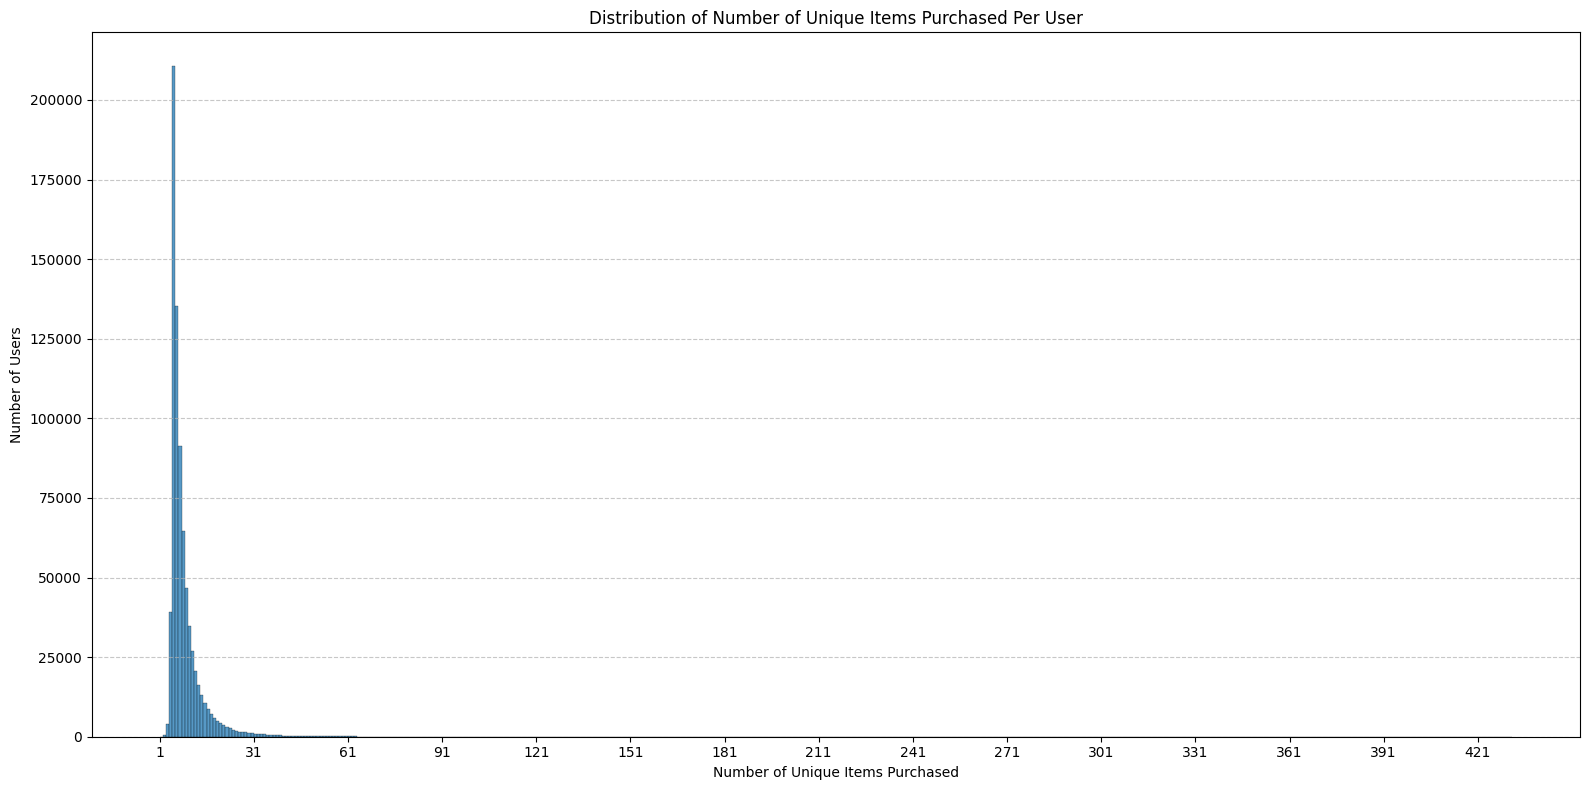

In [16]:
# Count the number of unique items (asin) purchased by each user (reviewerID)
items_per_user = df_subset.groupby('reviewerID')['asin'].nunique()

# Create a histogram of the distribution of items purchased per user
plt.figure(figsize=(16, 8))
sns.histplot(items_per_user, bins=range(1, items_per_user.max() + 2), kde=False)
plt.title('Distribution of Number of Unique Items Purchased Per User')
plt.xlabel('Number of Unique Items Purchased')
plt.ylabel('Number of Users')

# Get current x-axis limits and generate ticks for every 10th value
max_items = items_per_user.max()
plt.xticks(range(1, max_items + 1, 30))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
# Distribution of number of items rated
items_per_user.describe()

,asin
count,777242.00
mean,8.53
std,7.04
min,1.00
25%,5.00
50%,6.00
75%,9.00
max,431.00


In [18]:
# This counts how many users bought 1 item, how many bought 2 items, etc.
users_by_items_purchased = items_per_user.value_counts().sort_index()

# Convert to DataFrame for better display
df_users_by_items = users_by_items_purchased.reset_index()
df_users_by_items.columns = ['Number of Unique Items Purchased', 'Number of Users']


df_users_by_items.sort_values(['Number of Users'], ascending=False).head(10)

,Number of Unique Items Purchased,Number of Users
4,5,210717
5,6,135427
6,7,91459
7,8,64590
8,9,46748
3,4,39180
9,10,34879
10,11,26847
11,12,20687
12,13,16170


In [19]:
# Number of reviews by user
items_per_user.sort_values(ascending=False)

,asin
reviewerID,
AVU1ILDDYW301,431
A23GFTVIETX7DS,350
A3AZI828WJN1CD,347
A2R1HUYHXV7H18,345
A2GP4EJIAA2OE0,337
...,...
AH0LDUEAFNE6E,1
A33SYPDSFFYJPT,1
AN5DAHULJBOTV,1


/tmp/ipython-input-247613833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['review_year'] = df_subset['unixReviewTime'].dt.year


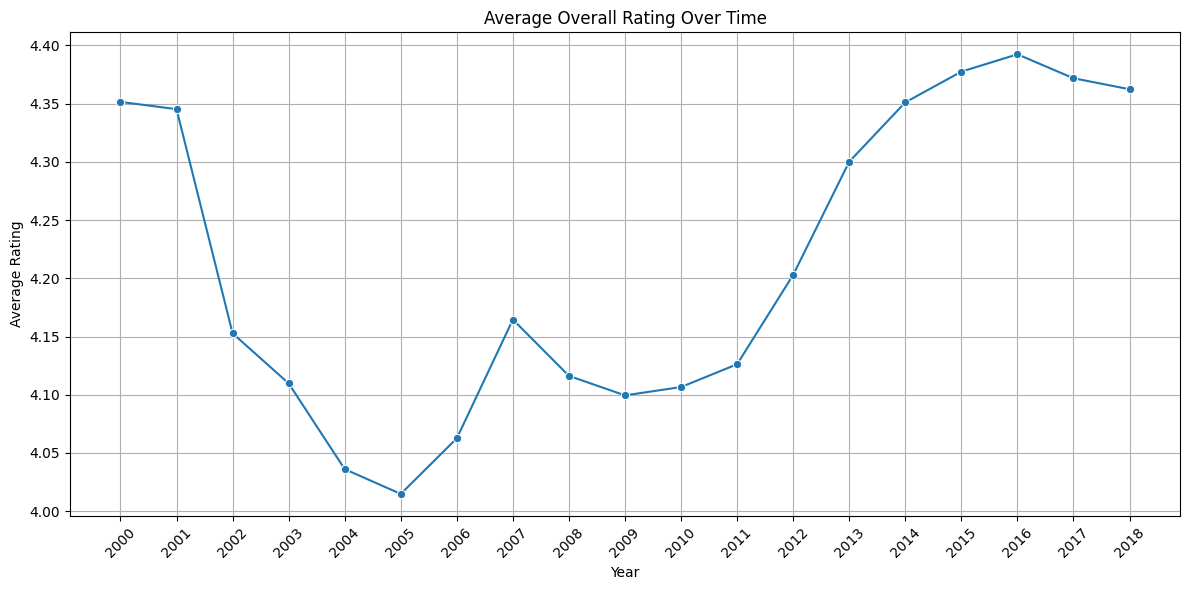

In [20]:
# Visualize average rating over time
# # Extract year from reviewTime for time-based analysis
df_subset['review_year'] = df_subset['unixReviewTime'].dt.year

# 1. Average Rating Over Time
average_ratings_by_year = df_subset.groupby('review_year')['overall'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='review_year', y='overall', data=average_ratings_by_year, marker='o')
plt.title('Average Overall Rating Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
# Set x-ticks to display integer years
plt.xticks(average_ratings_by_year['review_year'].unique(), rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

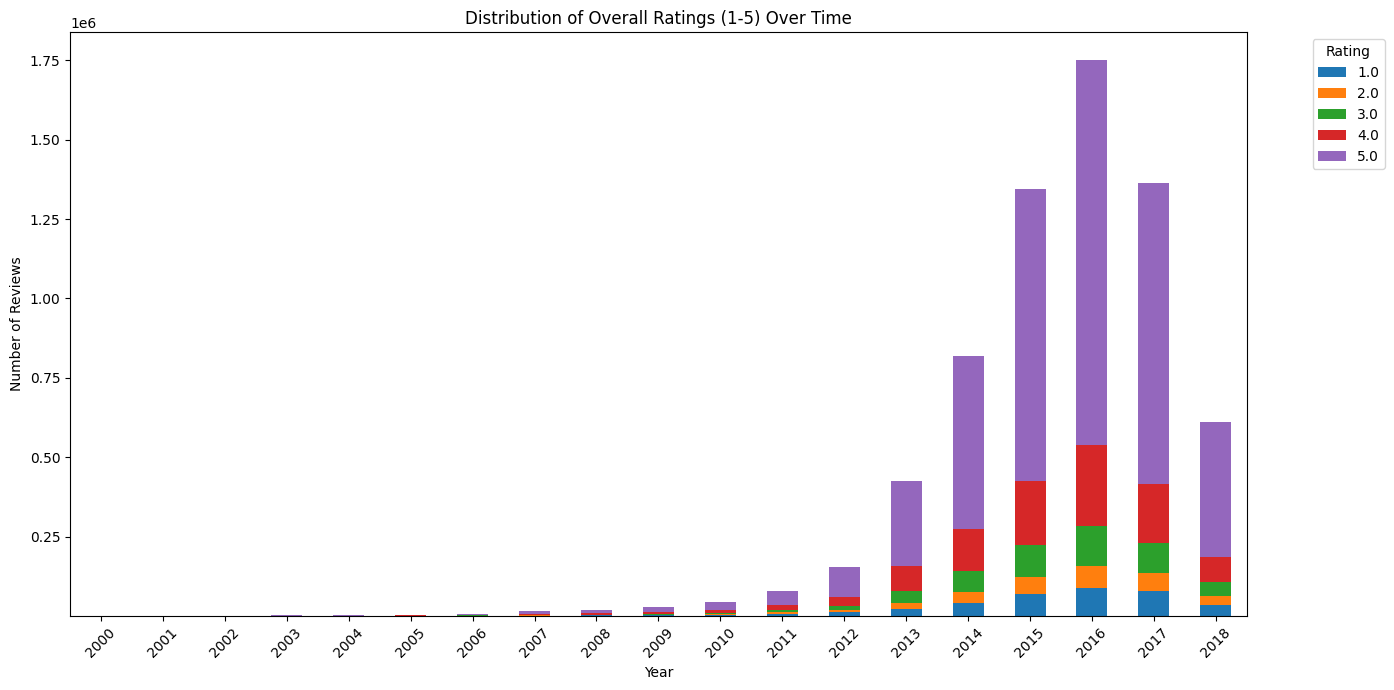

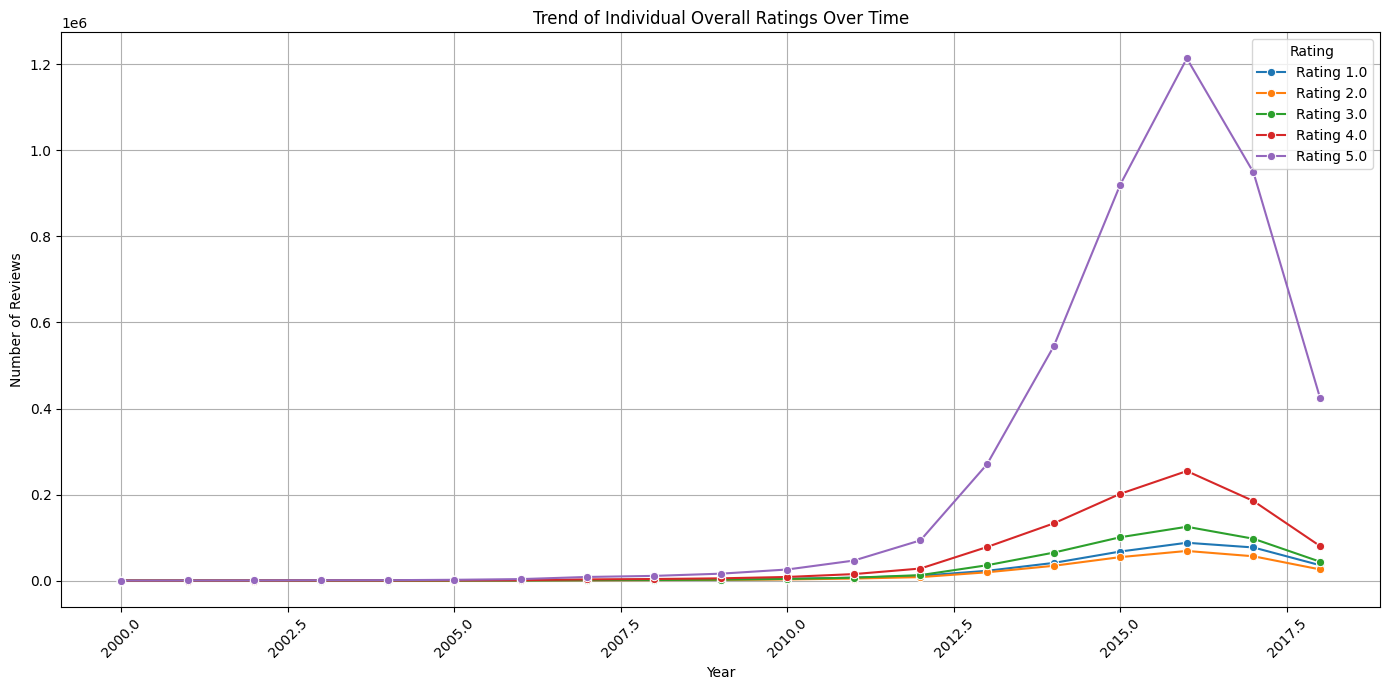

In [21]:
# 2. Distribution of Each Rating (1-5) Over Time
# Count occurrences of each rating per year
rating_distribution_by_year = df_subset.groupby(['review_year', 'overall']).size().unstack(fill_value=0)

# Plotting the distribution as a stacked bar chart or separate lines
plt.figure(figsize=(14, 7))
rating_distribution_by_year.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Distribution of Overall Ratings (1-5) Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Alternatively, as separate line plots for clearer trends of each rating
plt.figure(figsize=(14, 7))
for rating in sorted(df_subset['overall'].unique()):
    sns.lineplot(x=rating_distribution_by_year.index, y=rating_distribution_by_year[rating], label=f'Rating {rating}', marker='o')

plt.title('Trend of Individual Overall Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title='Rating')
plt.tight_layout()
plt.show()

## **Create function to return <u>the most popular items</u> up to a date**

In [22]:
def get_topn_popular_items(df, user_id, timestamp, n):
    """
    Returns the top-N most popular items up to a given timestamp
    that the user has NOT purchased yet.

    Parameters:
    - df: pandas DataFrame with columns ['reviewerID', 'asin', 'unixReviewTime']
    - user_id: the ID of the user (corresponds to 'reviewerID')
    - timestamp: cutoff time (recommend items purchased BEFORE this timestamp)
    - n: number of items to recommend

    Returns:
    - list of top-N item_ids (ASINs)
    """

    # 1️⃣ Filter data up to the given timestamp using 'unixReviewTime'
    df_up_to_t = df[df['unixReviewTime'] < timestamp]

    # 2️⃣ Get items the user has already purchased using 'reviewerID' and 'asin'
    user_purchased = set(df_up_to_t[df_up_to_t['reviewerID'] == user_id]['asin'])

    # 3️⃣ Count popularity of each item (number of purchases) using 'asin'
    item_counts = df_up_to_t.groupby('asin').size().sort_values(ascending=False)

    # 4️⃣ Filter out items the user has already purchased
    top_items = [item for item in item_counts.index if item not in user_purchased]

    # 5️⃣ Return top-N
    return top_items[:n]

In [23]:
def get_items_purchased_after_cutoff(df, user_id, cutoff_date):
    """
    Returns a list of unique items (ASINs) purchased by a given user
    after a specified cutoff date.

    Args:
        user_id (str): The ID of the user.
        cutoff_date (pd.Timestamp): The date after which to consider purchases.
        df (pd.DataFrame): The DataFrame containing 'reviewerID', 'asin', and 'unixReviewTime'.

    Returns:
        list: A list of unique ASINs purchased by the user after the cutoff date.
    """
    # Filter for the specific user and purchases after the cutoff date
    purchases_after_cutoff = df[
        (df['reviewerID'] == user_id) &
        (df['unixReviewTime'] > cutoff_date)
    ]

    # Return unique ASINs from these purchases
    return purchases_after_cutoff['asin'].unique().tolist()


## **Create function to recommend items based on co occurrence**

In [103]:
def compute_cooccurrence_before_time(df, cutoff_time):
    """
    Compute item–item co-occurrence matrix using implicit feedback.

    Any interaction (regardless of Review value) is treated as 1.
    Only interactions strictly before cutoff_time are used.

    Parameters
    ----------
    df : pandas.DataFrame
        Columns required:
            - 'reviewerID'
            - 'asin'
            - 'unixReviewTime' (datetime)
            - 'overall' (ignored for implicit modeling)

    cutoff_time : datetime
        Only interactions before this timestamp are used.

    Returns
    -------
    C : scipy.sparse.csr_matrix
        Sparse item–item co-occurrence matrix.

    items : pandas.Index
        Mapping of matrix indices to original item IDs.
    """

    # 1 Filter before cutoff
    mask = df["unixReviewTime"] < cutoff_time
    df_filtered = df.loc[mask, ["reviewerID", "asin"]]

    # 2 Convert to categorical codes
    user_cat = df_filtered["reviewerID"].astype("category")
    item_cat = df_filtered["asin"].astype("category")

    user_codes = user_cat.cat.codes.values
    item_codes = item_cat.cat.codes.values

    n_users = user_cat.cat.categories.size
    n_items = item_cat.cat.categories.size

    # 3 Build sparse user-item matrix
    X = csr_matrix(
        (np.ones(len(user_codes)), (user_codes, item_codes)),
        shape=(n_users, n_items)
    )

    # 4 Compute co-occurrence
    C = X.T @ X

    return C, item_cat.cat.categories

In [104]:
def cooccurrence_recommend_for_user_at_time(df, user_id, cutoff_time, n=5):
    """
    Recommend items for a given user using co-occurrence,
    based only on interactions before cutoff_time.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain:
            - 'reviewerID'
            - 'asin'
            - 'unixReviewTime' (datetime)

    user_id : str or int
        User identifier.

    cutoff_time : datetime
        Only interactions before this timestamp are used.

    n : int
        Number of recommendations to return.

    Returns
    -------
    recommendations : list
        List of recommended item IDs (asin).
    """

    # 1️⃣ Compute co-occurrence matrix before cutoff
    C, items = compute_cooccurrence_before_time(df, cutoff_time)

    # 2️⃣ Get user's history before cutoff
    user_mask = (
        (df["reviewerID"] == user_id) &
        (df["unixReviewTime"] < cutoff_time)
    )

    user_items = df.loc[user_mask, "asin"].unique()

    if len(user_items) == 0:
        return []

    # 3️⃣ Map item IDs to matrix indices
    item_to_index = {item: idx for idx, item in enumerate(items)}

    user_indices = [
        item_to_index[item]
        for item in user_items
        if item in item_to_index
    ]

    if not user_indices:
        return []

    # 4️⃣ Build user interaction vector
    user_vector = np.zeros(C.shape[0])
    user_vector[user_indices] = 1

    # 5️⃣ Compute scores
    scores = user_vector @ C
    scores = np.array(scores).flatten()

    # 6️⃣ Remove already purchased items
    scores[user_indices] = -1

    # 7️⃣ Get top-n items
    top_indices = np.argsort(scores)[-n:][::-1]

    recommendations = [
        items[i]
        for i in top_indices
        if scores[i] > 0
    ]

    return recommendations

## **Create functions for model evaluation**

**Example**
We consider 2 users with **top-5 recommended items**:

- User 1 purchased items `{A, C}`  
- User 2 purchased items `{B}`  
- Recommendations for both users (top-5): `[A, B, C, D, E]`

---

| Metric | Formula | Description | Example (2 users, 5 recommended items) |
|--------|---------|-------------|----------------------------------------|
| **Precision@K** | $$\text{Precision@K}_u = \frac{|R_u^K \cap P_u|}{K}$$ | Fraction of top-K recommended items that were actually purchased. In other words, TP/(TP+TN). If we recommend 5 items, and user later purchased 2 out of 5, then the precision is 2/5 = 0.4. The final is the average of all the precision scores for all the users.| **User 1:** 2/5 = 0.4 <br> **User 2:** 1/5 = 0.2 <br> **Average:** (0.4 + 0.2)/2 = 0.3 |
| **Recall@K** | $$\text{Recall@K}_u = \frac{|R_u^K \cap P_u|}{|P_u|}$$ | Fraction of all purchased items that appear in top-K recommendations. In other words, TP/(TP + FN). If the user purchased 3 items after we make the recommendations and out of the 3, 2 were in the list of 5 products that we recommended, then the recall is 2/3 = 0.66. The final is the average of all the precisions scores for all the users.| **User 1:** 2/2 = 1.0 <br> **User 2:** 1/1 = 1.0 <br> **Average:** (1.0 + 1.0)/2 = 1.0 |
| **Hit@K** | $$\text{Hit@K}_u = \begin{cases} 1 & \text{if } |R_u^K \cap P_u| \ge 1 \\ 0 & \text{otherwise} \end{cases}$$ | Binary metric: Did the user get **at least one relevant item** in the top-K? For example, if out of 5 items recommend the user later purchased >= 1, then the hit rate is 1 for that user (0 otherwise). The total hit rate is the avearege of all the hit rates for the user. | **User 1:** 1 <br> **User 2:** 0 (none of the recommended items were purhcased) <br> **Average:** (1+0)/2 = 0.5 |
| **DCG@K** | $$DCG@K = \sum_{i=1}^{K} \frac{rel_i}{\log_2(i+1)}$$ | Discounted Cumulative Gain measures **ranking quality**, giving more weight to relevant items appearing at the top. The matric is used to calculate **NDCG@k**. For example, if the order of items recommende is [A, B, C, D, E] and the user later purchased [A, C], then DCG@K equals 1/log2(2) + 0/log2(3) + 1/log2(4)... = 1.5| **User 1:** relevance `[1,0,1,0,0]` → DCG = 1/1 + 0 + 1/2 = 1.5 <br> **User 2:** relevance `[0,1,0,0,0]` → DCG = 1/1.585 ≈ 0.63 |
| **IDCG@K** | $$IDCG@K = \sum_{i=1}^{|P_u|} \frac{1}{\log_2(i+1)}$$ | Ideal DCG: maximum possible DCG if all purchased items are ranked at the top. Again, is used to calculade NDCG@k. It calculates the best possible scenario based on the user's purchases. For example, since the user pruchased [A, C] the ideal recommendation would have been [A, C, _, _, _] and the ideal value would have been 1/log2(2) + 1/log2(3) = 1.63| **User 1:** 2 items purchased → IDCG = 1/1 + 1/1.585 ≈ 1 + 0.63 = 1.63 <br> **User 2:** 1 item purchased → IDCG = 1/1 = 1 |
| **NDCG@K** | $$NDCG@K = \frac{DCG@K}{IDCG@K}$$ | Normalized DCG: rank-aware metric (0–1). Rewards having relevant items **near the top**. Is calculated by DCG@k/IDCG@K and from the example above equals to 1.5/1.63 = 0.92| **User 1:** 1.5 / 1.63 ≈ 0.92 <br> **User 2:** 0.63 / 1 ≈ 0.63 <br> **Average:** (0.92+0.63)/2 ≈ 0.775 |

In [26]:
def calculate_precision_at_k(recommended_items, actual_purchases, k):
    """
    Calculates Precision@K for a single user.

    Args:
        recommended_items (list): A list of recommended items.
        actual_purchases (list): A list of items actually purchased by the user.
        k (int): The number of top recommended items to consider.

    Returns:
        float: Precision@K score.
    """
    top_k_recommended = recommended_items[:k]
    if not top_k_recommended:
        return 0.0

    hits = len(set(top_k_recommended) & set(actual_purchases))
    precision = hits / k
    return precision

In [27]:
def calculate_recall_at_k(recommended_items, actual_purchases, k):
    """
    Calculates Recall@K for a single user.

    Args:
        recommended_items (list): A list of recommended items.
        actual_purchases (list): A list of items actually purchased by the user.
        k (int): The number of top recommended items to consider.

    Returns:
        float: Recall@K score.
    """
    if not actual_purchases:
        return 0.0  # or optionally skip this user when averaging

    top_k_recommended = recommended_items[:k]
    hits = len(set(top_k_recommended) & set(actual_purchases))
    recall = hits / len(actual_purchases)
    return recall

In [28]:
def calculate_hit_at_k(recommended_items, actual_purchases, k):
    """
    Calculates Hit@K for a single user.

    Args:
        recommended_items (list): A list of recommended item ASINs.
        actual_purchases (list): A list of item ASINs actually purchased by the user.
        k (int): The number of top recommended items to consider for evaluation.

    Returns:
        int: 1 if at least one recommended item in the top K is in actual purchases, 0 otherwise.
    """
    # Take only the top k items from the recommended list
    top_k_recommended_items = recommended_items[:k]

    if not top_k_recommended_items or not actual_purchases:
        return 0 # No hit if no recommendations or no actual purchases

    # Convert actual_purchases to a set for efficient lookup
    actual_purchases_set = set(actual_purchases)

    # Check if any of the top k recommended items are in the actual purchases
    for item in top_k_recommended_items:
        if item in actual_purchases_set:
            return 1 # Hit found

    return 0 # No hit

In [29]:
def calculate_dcg_at_k(recommended_items, actual_purchases, k):
    """
    Calculates Discounted Cumulative Gain (DCG@K) for a single user.

    Args:
        recommended_items (list): A list of recommended item ASINs, ordered by relevance.
        actual_purchases (list): A list of item ASINs actually purchased by the user.
        k (int): The number of top recommended items to consider for evaluation.

    Returns:
        float: The DCG@K score.
    """
    top_k_recommended = recommended_items[:k]
    if not top_k_recommended:
        return 0.0

    actual_purchases_set = set(actual_purchases)
    dcg = 0.0
    for i, item in enumerate(top_k_recommended):
        relevance = 1 if item in actual_purchases_set else 0
        # Discount factor: log2(position + 1)
        # Position is 0-indexed, so it's i+1. log2(i+1 + 1) = log2(i+2)
        dcg += relevance / math.log2(i + 2)
    return dcg

def calculate_idcg_at_k(actual_purchases, k):
    """
    Calculates Ideal Discounted Cumulative Gain (IDCG@K) for a single user.
    This represents the maximum possible DCG if all relevant items were ranked at the top.

    Args:
        actual_purchases (list): A list of item ASINs actually purchased by the user.
        k (int): The number of top positions to consider for the ideal ranking.

    Returns:
        float: The IDCG@K score.
    """
    if not actual_purchases:
        return 0.0

    # The ideal scenario is to place all relevant items (up to k) at the top
    # We assume relevance = 1 for all actual purchases
    num_relevant_items = min(len(actual_purchases), k)
    idcg = 0.0
    for i in range(num_relevant_items):
        # For ideal ranking, all relevant items have relevance = 1
        idcg += 1 / math.log2(i + 2)
    return idcg

def calculate_ndcg_at_k(recommended_items, actual_purchases, k):
    """
    Calculates Normalized Discounted Cumulative Gain (NDCG@K) for a single user.

    Args:
        recommended_items (list): A list of recommended item ASINs, ordered by relevance.
        actual_purchases (list): A list of item ASINs actually purchased by the user.
        k (int): The number of top recommended items to consider for evaluation.

    Returns:
        float: The NDCG@K score (value between 0 and 1).
    """
    dcg = calculate_dcg_at_k(recommended_items, actual_purchases, k)
    idcg = calculate_idcg_at_k(actual_purchases, k)

    if idcg == 0:
        return 0.0 # Cannot normalize if IDCG is zero (no actual purchases or k is 0)

    return dcg / idcg

## **Test Model Performance**

In [113]:
user_id = 'A8LUWTIPU9CZB'
cutoff_time = timestamp=pd.Timestamp('2016-11-05')

Test performance of the **most popular item** recommendation on a single user

In [115]:
# Check most popular items before the cutoff date recommende to the user
items_recommended = get_topn_popular_items(df_subset,
                                           user_id,
                                           cutoff_time,
                                           n=20)
items_recommended

['B00FLYWNYQ',
 'B00COK3FD8',
 'B00902X68W',
 'B00NX47YP4',
 'B000M8YMEU',
 'B007WQ9YNE',
 'B000YGEVMI',
 'B000VENLF6',
 'B000BWZ7QO',
 'B00JVLG2KG',
 'B002S52ZDU',
 'B0091YYUAM',
 'B002KAPNA0',
 'B0015TMHSI',
 'B009HVH4XO',
 'B014P3B7TU',
 'B00AYULZEQ',
 'B00009R66F',
 'B00ARQVLGO',
 'B00EQT70QS']

In [116]:
# Check the actual items that the user purchased after the cutoff date
items_purchased = get_items_purchased_after_cutoff(df_subset,
                                                   user_id,
                                                   cutoff_time)
items_purchased

['B004UC0GIU', 'B00R3Z4CWC', 'B00R9WRM4Y', 'B01DCG3WR6']

In [117]:
# For most popular items, calculate precision, recall, hit and dcg for the user

print(f'Precision@k', calculate_precision_at_k(items_recommended, items_purchased, 3))
print(f'Recall@k', calculate_recall_at_k(items_recommended, items_purchased, 3))
print(f'Hit@k', calculate_hit_at_k(items_recommended, items_purchased, 3))
print(f'NDSG@k', calculate_ndcg_at_k(items_recommended, items_purchased, 3))

Precision@k 0.0
Recall@k 0.0
Hit@k 0
NDSG@k 0.0


Test performance of **co occurrence recommendation** on a single user

In [118]:
items_recommended_cooccur = cooccurrence_recommend_for_user_at_time(df_subset,
                                                                    user_id,
                                                                    cutoff_time)
items_recommended_cooccur

['B002J4BWV6', 'B00BCQ4D9A', 'B009ZHYTPQ', 'B002FOFFW2', 'B00FYOB0S8']

In [119]:
# For co occured items, calculate precision, recall, hit and dcg for the user

print(f'Precision@k', calculate_precision_at_k(items_recommended_cooccur, items_purchased, 3))
print(f'Recall@k', calculate_recall_at_k(items_recommended_cooccur, items_purchased, 3))
print(f'Hit@k', calculate_hit_at_k(items_recommended_cooccur, items_purchased, 3))
print(f'NDSG@k', calculate_ndcg_at_k(items_recommended_cooccur, items_purchased, 3))

Precision@k 0.0
Recall@k 0.0
Hit@k 0
NDSG@k 0.0
